# Exploring the results from SCENIC: 

Once the results from the analysis are ready, you can choose to explore them in the web platform ([SCope](http://scope.aertslab.org/)), in R, or in *python*.

In this notebook we will use first **SCope** to get a view of some regulons and marker genes, and then we will provide some examples for the analysis in **R**.

Most of the relevant analyses can be done both in Scope and in R/python. Choosing one or the other is mostly a matter of convenience. Users that don't feel comfortable with code might want to stick to SCope, while R/python are very useful for automating analyses and reports.

In real analyses it might be useful to have an iterative approach: e.g. Create an "automated" report in R to get an initial overview of regulons (e.g. based on this notebook), check some of the interesting markers and regulons in SCope to get a more clear view of the clusters... and come back to R to make more personalized figures.


## Exploring results in SCope

Upload the loom file to http://scope.aertslab.org, and it will appear on the "User uploaded" files... 

> For this tutorial we have already uploaded the loom file to this session:
https://scope.aertslab.org/#/qlife_winter_school/*/welcome

SCope allows to visualize different features projected on 2D-embeddings (available options are listed on the left menu). Some examples on how to navigate the website are given in these screenshots. 
A few more notes on interpretation are given in the examples using R.

- Marker genes:
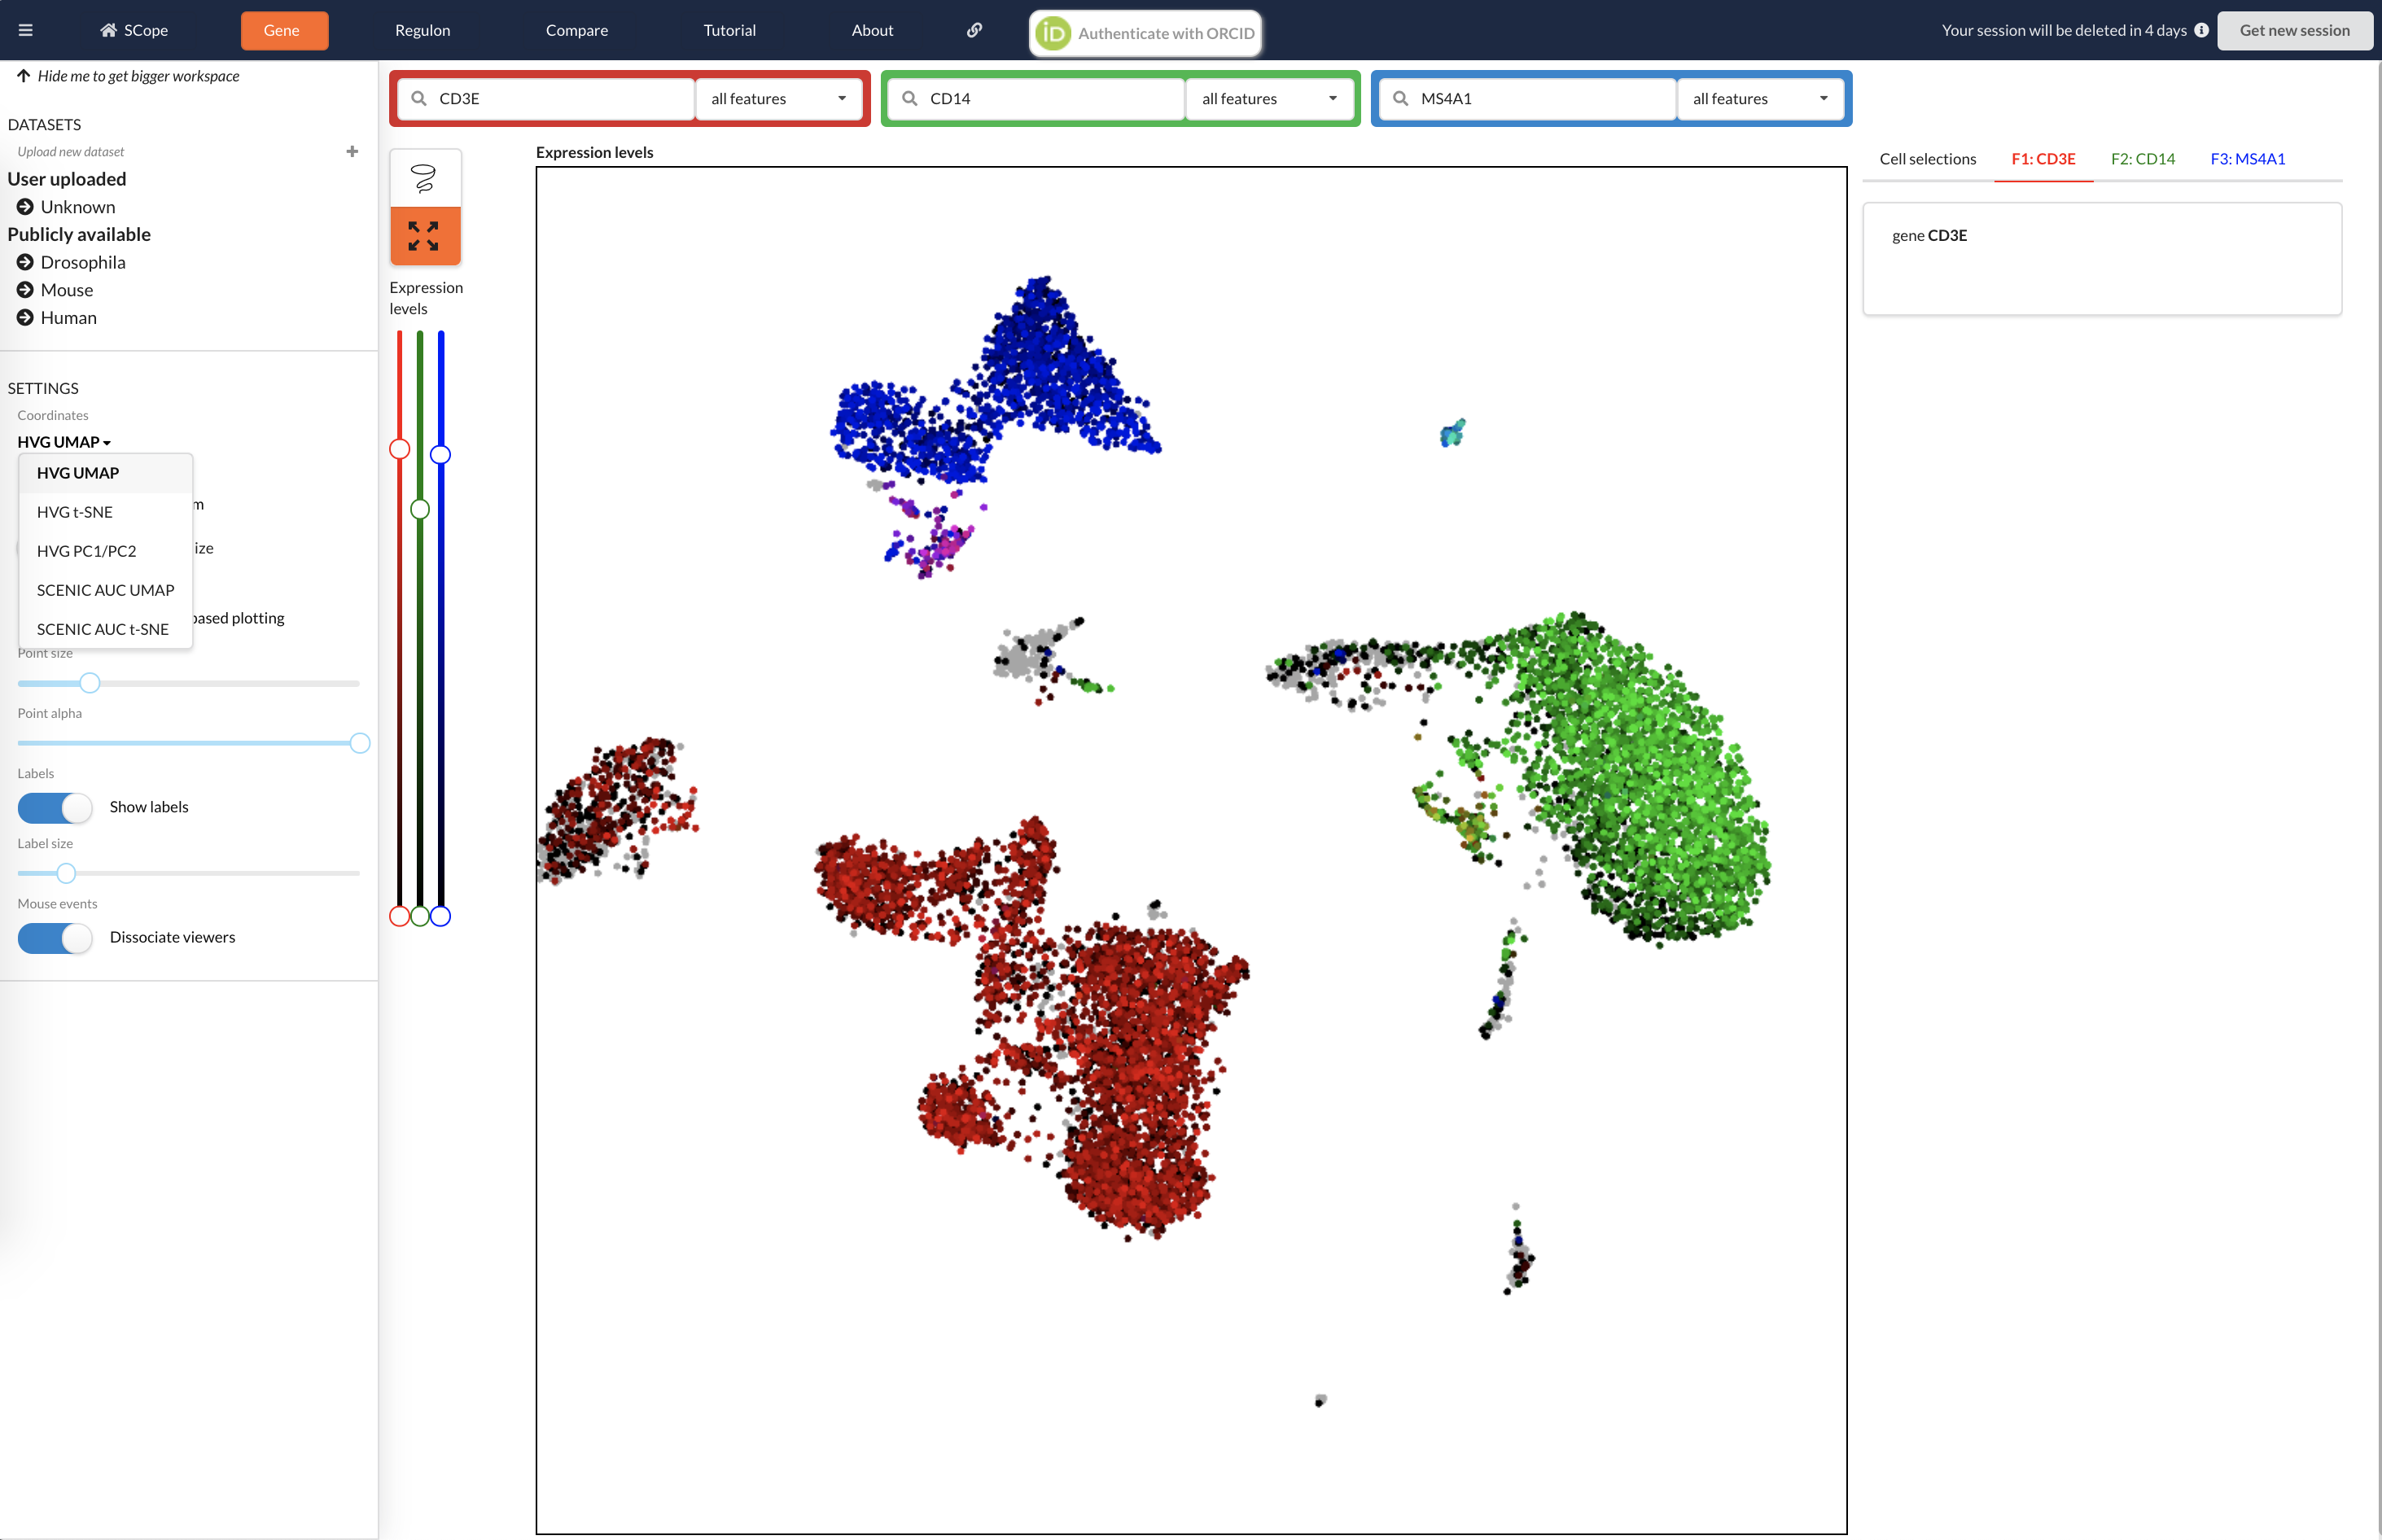

- Clusters or cell type annotations (i.e. from Scanpy, Seurat, or manual annotation, the results can be stored in the same file): 
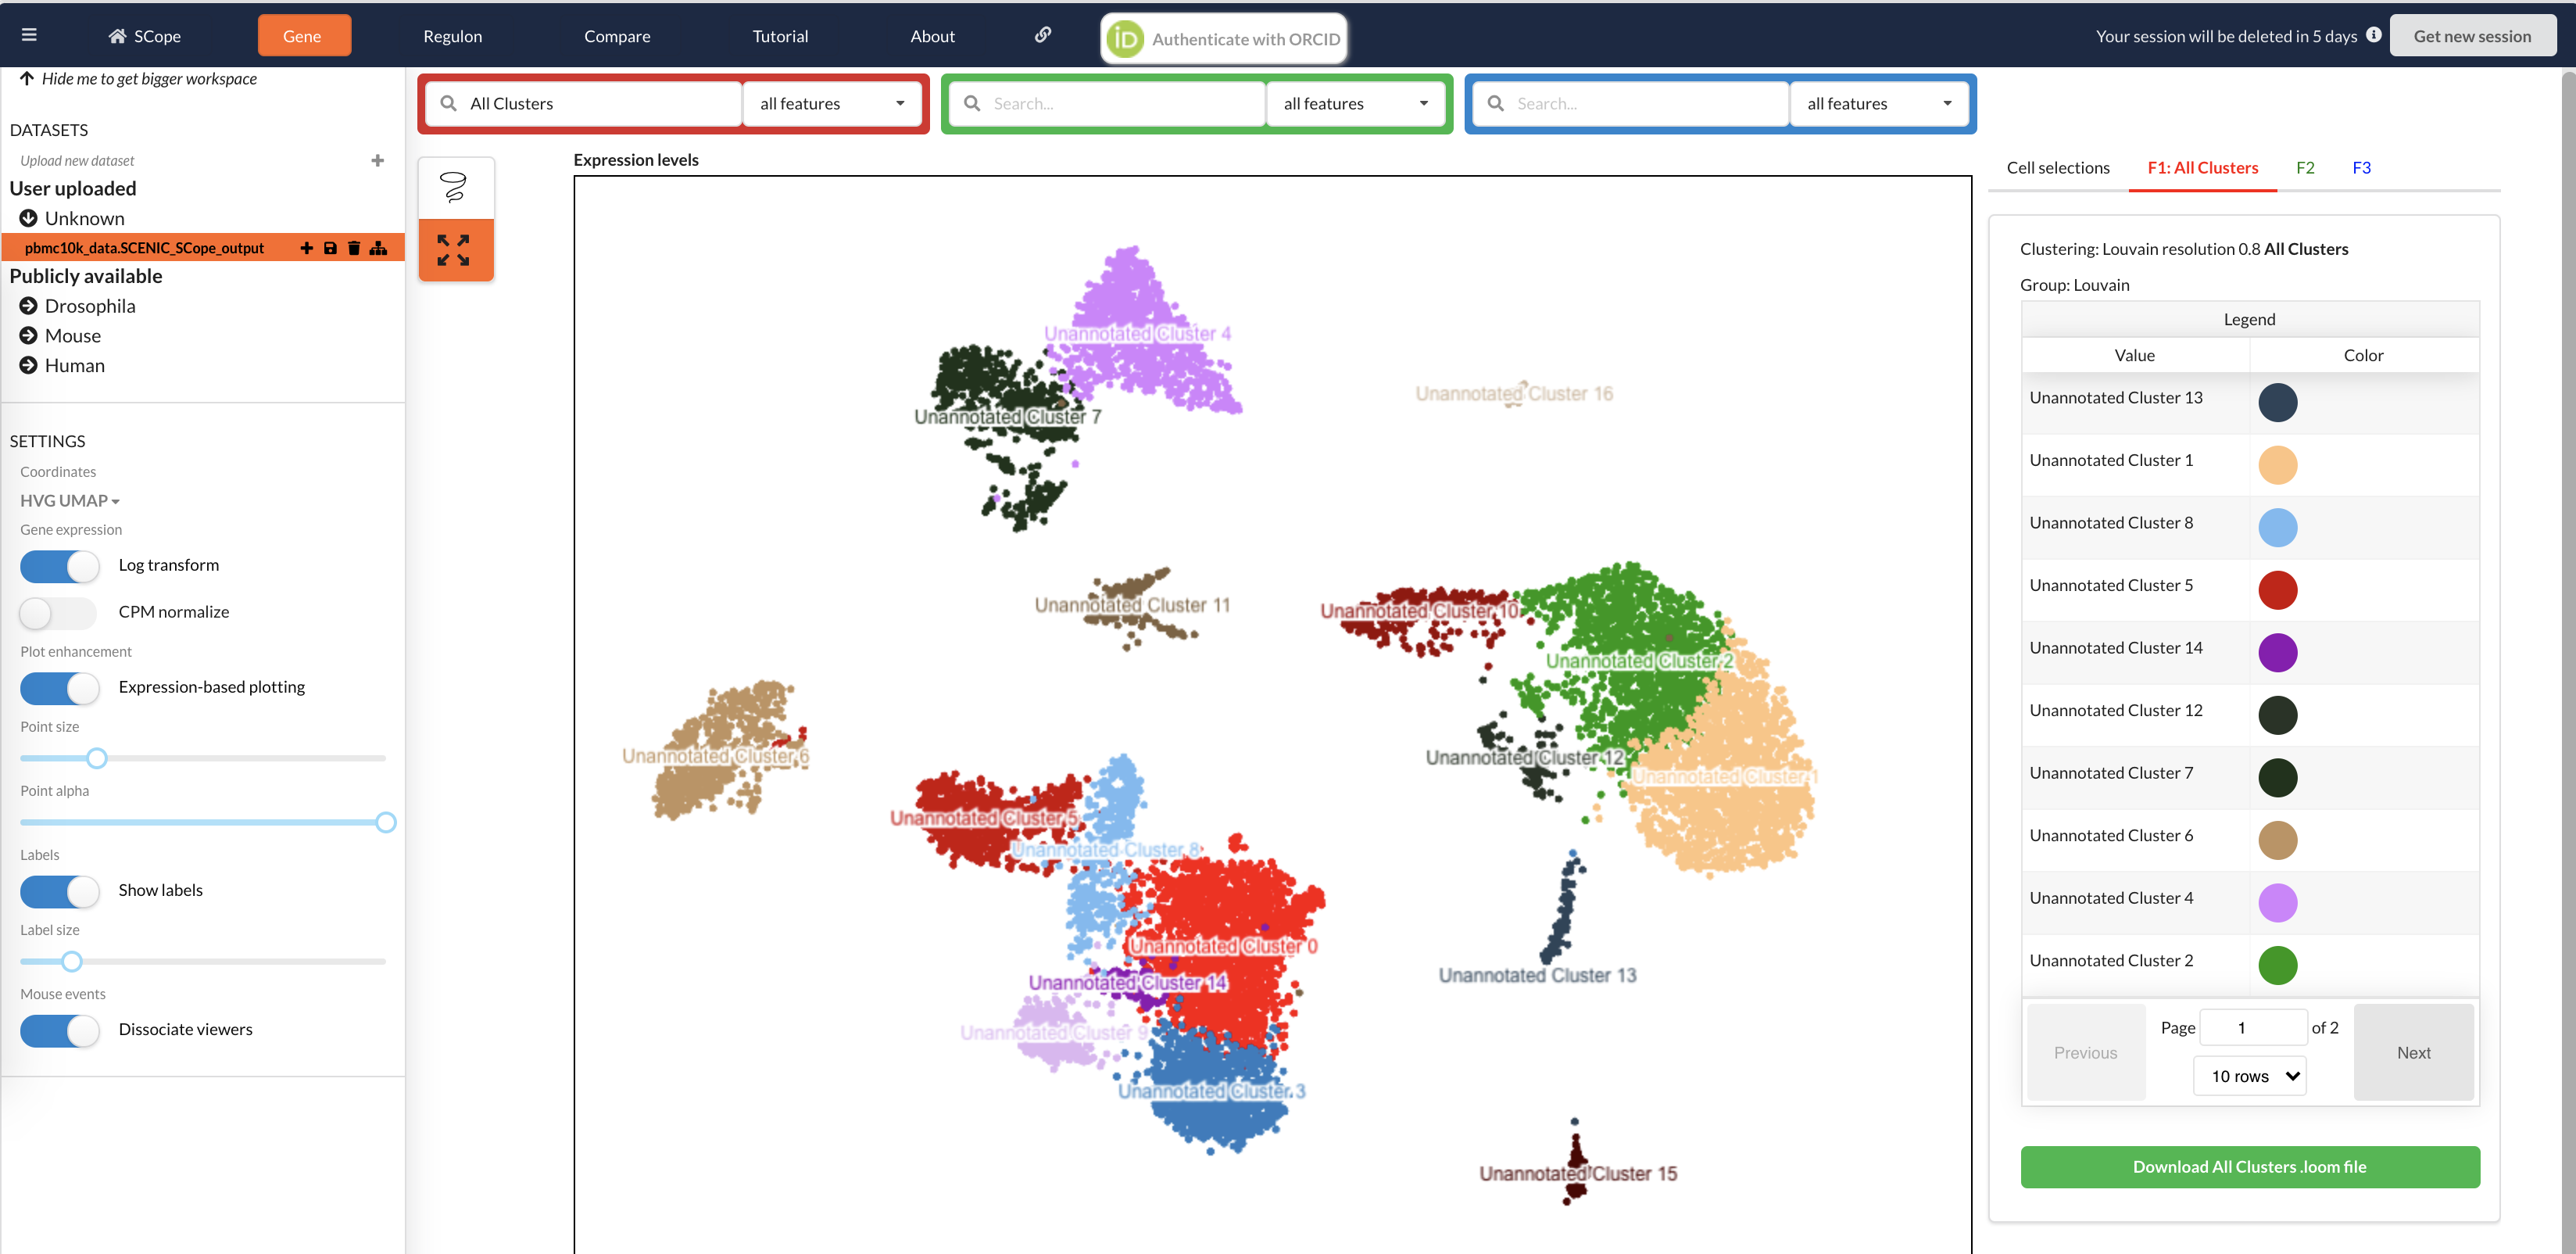

> In the "compare" tab, you can also subset cells by annotation and compare them to each other...

- The GRN information. For example, the "regulon" tab allows to view the regulon activity, TF expression and motif at once:
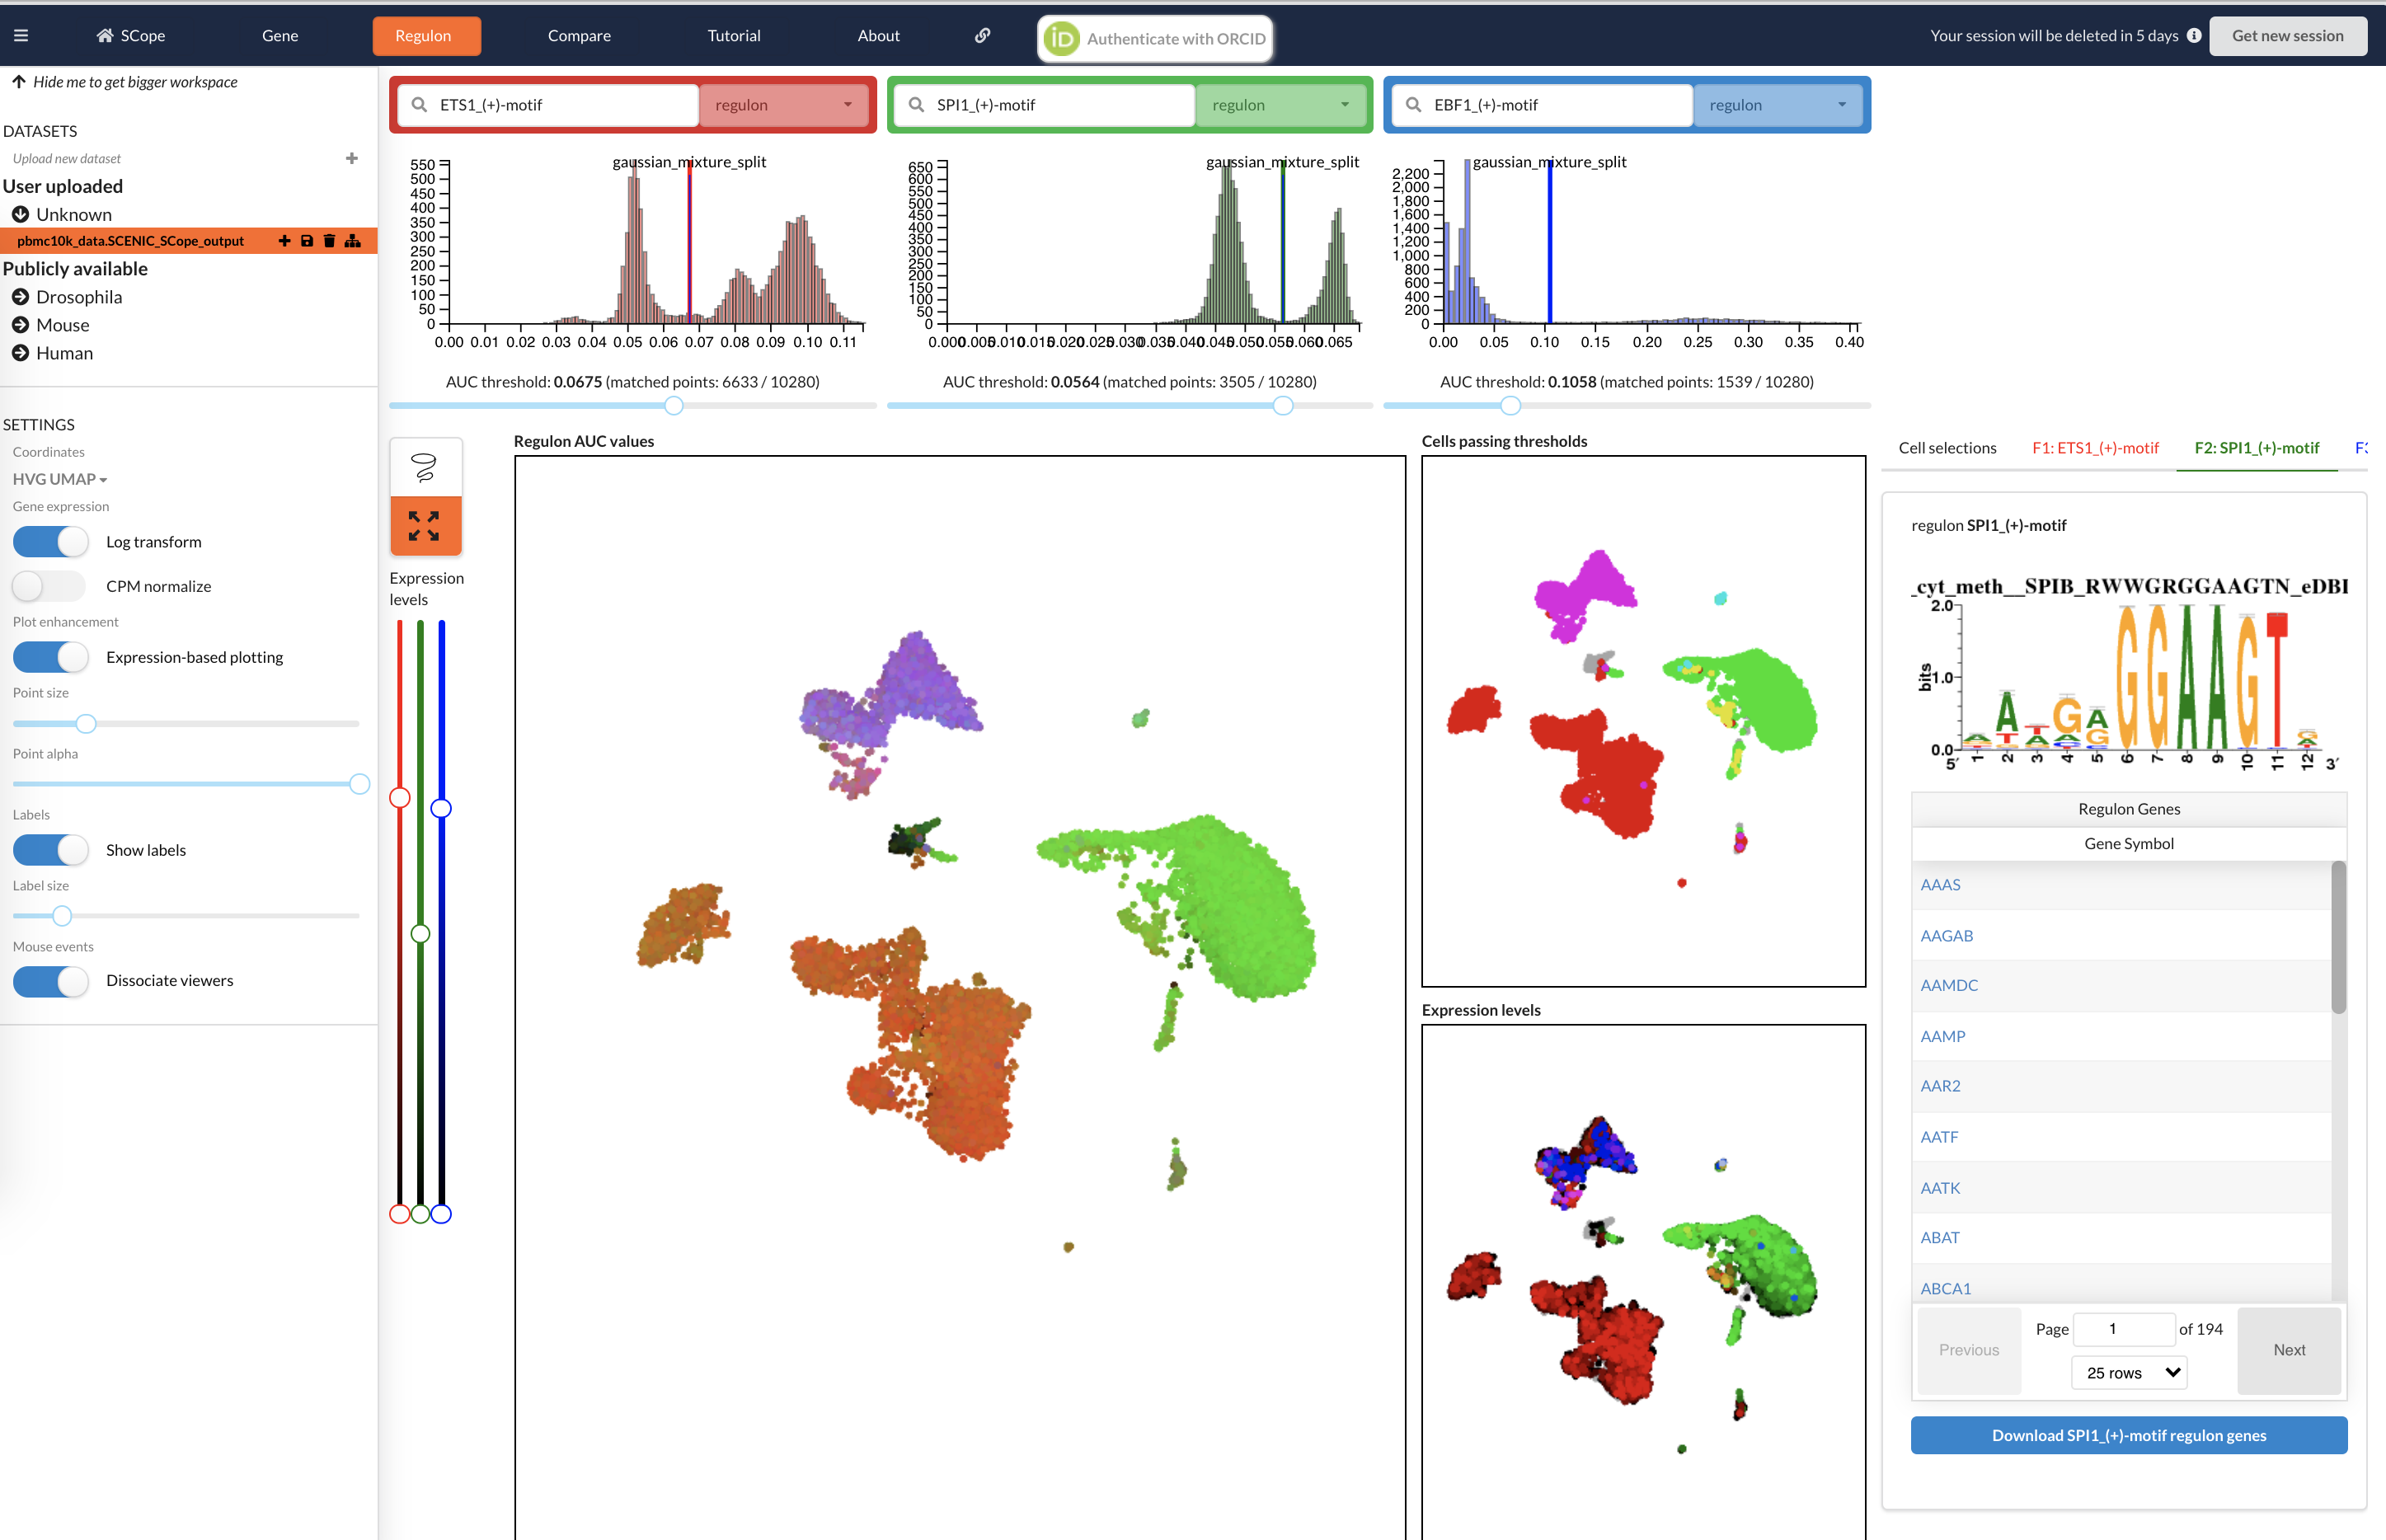

> Note that when searching for a given gene, it will also list regulons in which the gene is included...
(e.g. `CD3E <- ETS1; CD14 <- SPI1; MS4A1 <- EBF1`)

## Exploring results in R

In this notebook we will start by:

- Loading the results from a loom file

Then we will use three typical case studies as examples on how to explore the results:

- Finding regulators for known cell types

- Finding cell states based on the GRN activity

- Exploring the networks in detail (i.e. TFs, target genes and motifs)

Before starting, let's load the required packages:

In [ ]:
# Required packages:
library(SCopeLoomR)
library(AUCell)
library(SCENIC)

# For some of the plots:
#library(dplyr)
library(KernSmooth)
library(RColorBrewer)
library(plotly)
library(BiocParallel)
library(grid)
library(ComplexHeatmap)
library(data.table)

In [ ]:
packageVersion("SCENIC")

Set the work directory and files to import:

> You should have write permissions to the working directory (i.e. to save figures...)

> The working directory can be the same as where VSN-SCENIC results are located (i.e. `vsnDir="."`), or any other location (for example, if you have not run VSN-SCENIC yourself and don't have write permissions, or do not want to overwrite previous figures). 

In [ ]:
setwd("~/Tutorials/SCENIC_pbmc")
vsnDir <- "." 

In [ ]:
scenicLoomPath <- file.path(vsnDir, "out/loom/pbmc10k_data.SCENIC_SCope_output.loom")
motifEnrichmentFile <- file.path(vsnDir, "out/scenic/pbmc10k_data/cistarget/pbmc10k_data__reg_mtf.csv.gz")
file.exists(scenicLoomPath)
file.exists(motifEnrichmentFile)

In [ ]:
list.files() #  What is already in the current work dir?

### Loading results from a .loom file

The main results from SCENIC included in the loom .file are: 

- Regulons (TF and target genes)

- Regulon activity (AUC matrix and thresholds)

- Embeddings (e.g. t-SNE and UMAP on the regulon activity)

The **motif enrichment analysis** and **co-expression modules** (e.g. GRNBoost/GENIE3 output) are stored in independent text files (mostly due to their bigger size).

The package `SCopeLoomR` provides the interface to import the regulons, AUC, and embeddings back from a loom file.
Extra help (e.g. adding/extracting other types of data, such as markers or clusters), can be found with `help(package="SCopeLoomR")`.

In [ ]:
library(SCopeLoomR)
loom <- open_loom(scenicLoomPath)
    # Read information from loom file:
    exprMat <- get_dgem(loom)
        exprMat_log <- log2(exprMat+1) # Better if it is logged/normalized
    regulons_incidMat <- get_regulons(loom, column.attr.name="MotifRegulons")
        regulons <- regulonsToGeneLists(regulons_incidMat)
    regulonAUC <- get_regulons_AUC(loom)
    regulonAucThresholds <- get_regulon_thresholds(loom)
    embeddings <- get_embeddings(loom)
    cellClusters <- get_clusterings(loom)
close_loom(loom)

In [ ]:
# In case you need help:
?get_regulons

In [ ]:
### To check whether it was read properly:
# length(regulons);  head(names(regulons))
# regulonAUC
# length(regulonsAucThresholds)
# plot(embeddings$`SCENIC AUC UMAP`)

Also load the motif enrichment results:

In [ ]:
motifEnrichment <- data.table::fread(motifEnrichmentFile, header=T, skip=1)[-3,]
colnames(motifEnrichment)[1:2] <- c("TF", "MotifID")

### Scoring the network activity

The networks provided by SCENIC are based on `regulons`, each regulon includes a TF and its potential target genes. 

One of the advantages of SCENIC is that in addition to providing the regulons, it also provides a measure of their activity on each of the individual cells. 
This is achieved using `AUCell`, which provides an `AUC` value indicating the relative expression of the genes in the regulon (as a whole) in each cell. This allows to perform further analyses, such as identifying which regulons are more active in specific cell types, or finding cell states based on the activity of the networks.

Here we provide a few examples that can be used as default analyses, but feel free to try new combinations (your imagination is the limit!). 

The regulon activity is one of the results we loaded from the loom file:

In [ ]:
regulonAUC

### Regulators for known cell types or clusters

The regulatory analysis from SCENIC can be combined with other types of analyses for single-cell RNA-seq data. 
For example, if you already have cell clusters or some cell annotations for your dataset, an easy way to start the analysis is finding TFs that could be acting as key regulators. 

- **Average Regulon Activity** per cluster

Visualizing the regulon activity per cluster can help get a global overview of the TFs in your dataset. 
Note that the default VSN pipeline already produces a heatmap with the individual cells. This is a complementary heatmap showing the average per cluster.

In [ ]:
# To start from clusters/cell types from Scanpy: 
head(cellClusters)

In [ ]:
selectedResolution <- "0" # select resolution
# Split the cells by cluster:
cellsPerCluster <- split(rownames(cellClusters), cellClusters[,selectedResolution]) 
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]
# Calculate average expression:
regulonActivity_byCellType <- sapply(cellsPerCluster,
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
# Scale expression:
regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))

In [ ]:
# plot:
options(repr.plot.width=8, repr.plot.height=10) # To set the figure size in Jupyter
hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byCellType_Scaled, name="Regulon activity",
                       row_names_gp=grid::gpar(fontsize=6))) # row font size
regulonOrder <- rownames(regulonActivity_byCellType_Scaled)[row_order(hm)] # to save the clustered regulons for later

To see the exact values:

In [ ]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Scaled)
colnames(topRegulators) <- c("Regulon", "CellType", "RelativeActivity")
topRegulators$CellType <- factor(as.character(topRegulators$CellType))
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>0),]
dim(topRegulators)

In [ ]:
viewTable(topRegulators, options = list(pageLength = 10))

- **Cell-type specific** regulators

To identify cluster-specific regulons (especially for analyses with many cell types, where some regulons are common to multiple of them) we find specially useful the **Regulon Specificity Score (RSS)** (proposed by Suo et al. for the Mouse Cell Atlas in 2018).

To calculate and visualize the RSS:

In [ ]:
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=cellClusters[colnames(regulonAUC), selectedResolution])

In [ ]:
## Showing regulons and cell types with any RSS > 0.01 
rssPlot <- plotRSS(rss)
plotly::ggplotly(rssPlot$plot)

In [ ]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "4") # cluster ID

*Exercises*:
- Compare the average regulon Activity heatmaps and the RSS score: Find a few TFs that have a similar profile in both (e.g. specific for a cell type) and a few with different. Do you understand why? e.g. in the averaged heatmap there are regulons that are active across many cell types, while the RSS highlights the ones that are exclussive for each cell type.

- Compare the Regulon Activity heatmaps: averaged by cluster (above) and cell-based (available in the automatic report from VSN (`out/scenic/pbmc10k_data/notebooks/SCENIC_report.html`). Which advantages/dissadvantages do you see for using each one?

- Go back to SCope and check some of these regulons.

### Cell states based on the GRN activity


To explore whether there are groups of cells that tend to have the same regulons active, and reveal the network states that are recurrent across multiple cells, we can cluster the cells based on this regulon activity (either the continuous or binary AUC matrix). 
These states would be equivalent to the *attractor states* of the network, and they can match the known cell types, or provide a new/complementary view of the data. 

SCENIC provides some wrapper functions to get a quick overview and detect potential **associations of cell types or states with specific regulons**. For example, visualizing the AUC as heatmaps (like in the previous section) or projecting the AUC and TF expression onto 2D projections (such as t-SNE and Umap). 

> **t-SNE** and **Umap** are two 2D projection techniques where cells (dots) are placed close to each other if they have similar input profiles (in our case, regulon activity).


**2D embeddings** of the cells are often used to get a quick and easy overview of the cell states in the dataset. 

By default, VSN provides two types of projections, based on the regulatory networks (SCENIC) and based on highly variable genes (HVG, using Scanpy).

In this section we focus on the 2D projections calculated based on the regulon scores (i.e. to explore the **GRN-based states**) but the AUC can also be visualized on projections obtained by other methods (e.g. Umaps based on HGV with Seurat or Scanpy).

Here we have an example projecting TF and regulon activity on the 2D-embeddings:

In [ ]:
# List of embeddings available:
cat(names(embeddings), sep="\n")

In [ ]:
# Overview of these embeddings (see below for details)
regulonsToPlot <- "ETS1_(+)-motif"
options(repr.plot.width=10, repr.plot.height=8) # To set the figure size in Jupyter
par(mfrow=c(2, ceiling(length(names(embeddings))/2)))
for (selectedEmbedding in names(embeddings))
    AUCell::AUCell_plotTSNE(embeddings[[selectedEmbedding]], exprMat_log, regulonAUC[regulonsToPlot,], plots=c("AUC"), cex = .5, 
                            sub=selectedEmbedding)

Let's use the GRN-based UMAP:

In [ ]:
selectedEmbedding <- embeddings[["SCENIC AUC UMAP"]] # change if desired...

The function `AUCell_plotTSNE` allows to project into an embedding the TF expression and the Regulon activity ("AUC" or "binarized", and the distribution "histogram") in a similar way to SCOPE.

Let's plot these for a few selected TFs (for an automated analysis previous to checking the results, you could add for example the top TFs for a cluster):

In [ ]:
tfsToPlot <- c("ETS1", "SPI1", "EBF1") 
regulonsToPlot <- unlist(lapply(tfsToPlot, function(x) grep(paste0("^", x,"_"), rownames(regulonAUC), value=TRUE)))
                                
options(repr.plot.width=10, repr.plot.height=8) # To set the figure size in Jupyter
par(mfrow=c(2,3))
# Plot expression:
AUCell::AUCell_plotTSNE(selectedEmbedding, exprMat_log[tfsToPlot,], plots=c("Expression"), cex = .5)
# Plot regulon activity:
AUCell::AUCell_plotTSNE(selectedEmbedding, exprMat_log, regulonAUC[regulonsToPlot,], plots=c("AUC"), cex = .5)

Or you can plot all at once (for example saving them into a pdf):

In [ ]:
# Subset some cells to make the plots faster:
nCells <- 1000
set.seed(123)
cellsSelected <- sample(colnames(regulonAUC), nCells) 
regulonAUC_subset <- regulonAUC[regulonOrder, which(colnames(regulonAUC) %in% cellsSelected)]
dim(regulonAUC_subset)
selectedEmbedding_subset <- selectedEmbedding[colnames(regulonAUC_subset), ]

# Save AUC as PDF:
pdf("RegulonActivity.pdf", width=20, height=15)
par(mfrow=c(4,6))
AUCell::AUCell_plotTSNE(selectedEmbedding_subset, cellsAUC=regulonAUC_subset, plots="AUC")
dev.off()

Density plot to detect most likely stable states (higher-density areas in the t-SNE):

In [ ]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
library(KernSmooth)
library(RColorBrewer)
dens2d <- bkde2D(selectedEmbedding, .5)$fhat
image(dens2d, col=brewer.pal(9, "YlOrBr"), axes=FALSE)
contour(dens2d, add=TRUE, nlevels=6, drawlabels=FALSE)

- **Binarized regulon activity**

In order to find GRN-based cell states, sometimes it is also useful to binarize the Regulon activity score into "on"/"off". The resulting binarized activity matrix can be used for performing a new 2D projection or clustering, which might reveal more specific GRN-based cell states. We found this specially helpful for the analysis of cancer datasets, which allowed to overcome the patient-of origin "batch" effect, and find meaningful cancer states (see SCENIC paper).

SCENIC already calculates a set of default thresholds (which might need to be adjusted for some regulons):

In [ ]:
head(as.data.frame(regulonAucThresholds))

These can also be plotted with `AUCell_plotTSNE`: 

In [ ]:
regulonsToPlot <- "ETS1_(+)-motif"
options(repr.plot.width=10, repr.plot.height=4) # To set the figure size in Jupyter
par(mfrow=c(1,3))
AUCell::AUCell_plotTSNE(selectedEmbedding, exprMat_log, 
                        regulonAUC[regulonsToPlot,], thresholds = regulonAucThresholds[regulonsToPlot],
                        plots=c("AUC", "histogram", "binary"), cex = .5)

To explore and select the binarization thresholds interactivelly within R, AUCell also provides a shiny app.
Unfortunatelly, it does not work within Jupyter, so we will skip this part in this tutorial, but if you are interested, you are encouraged to check the regular R vignette:
```{r}
aucellApp <- AUCell_createViewerApp(auc=regulonAUC,
                                    thresholds=regulonAucThresholds,
                                    tSNE=selectedEmbedding, 
                                    exprMat=exprMat_log)
savedSelections <- shiny::runApp(aucellApp)
```
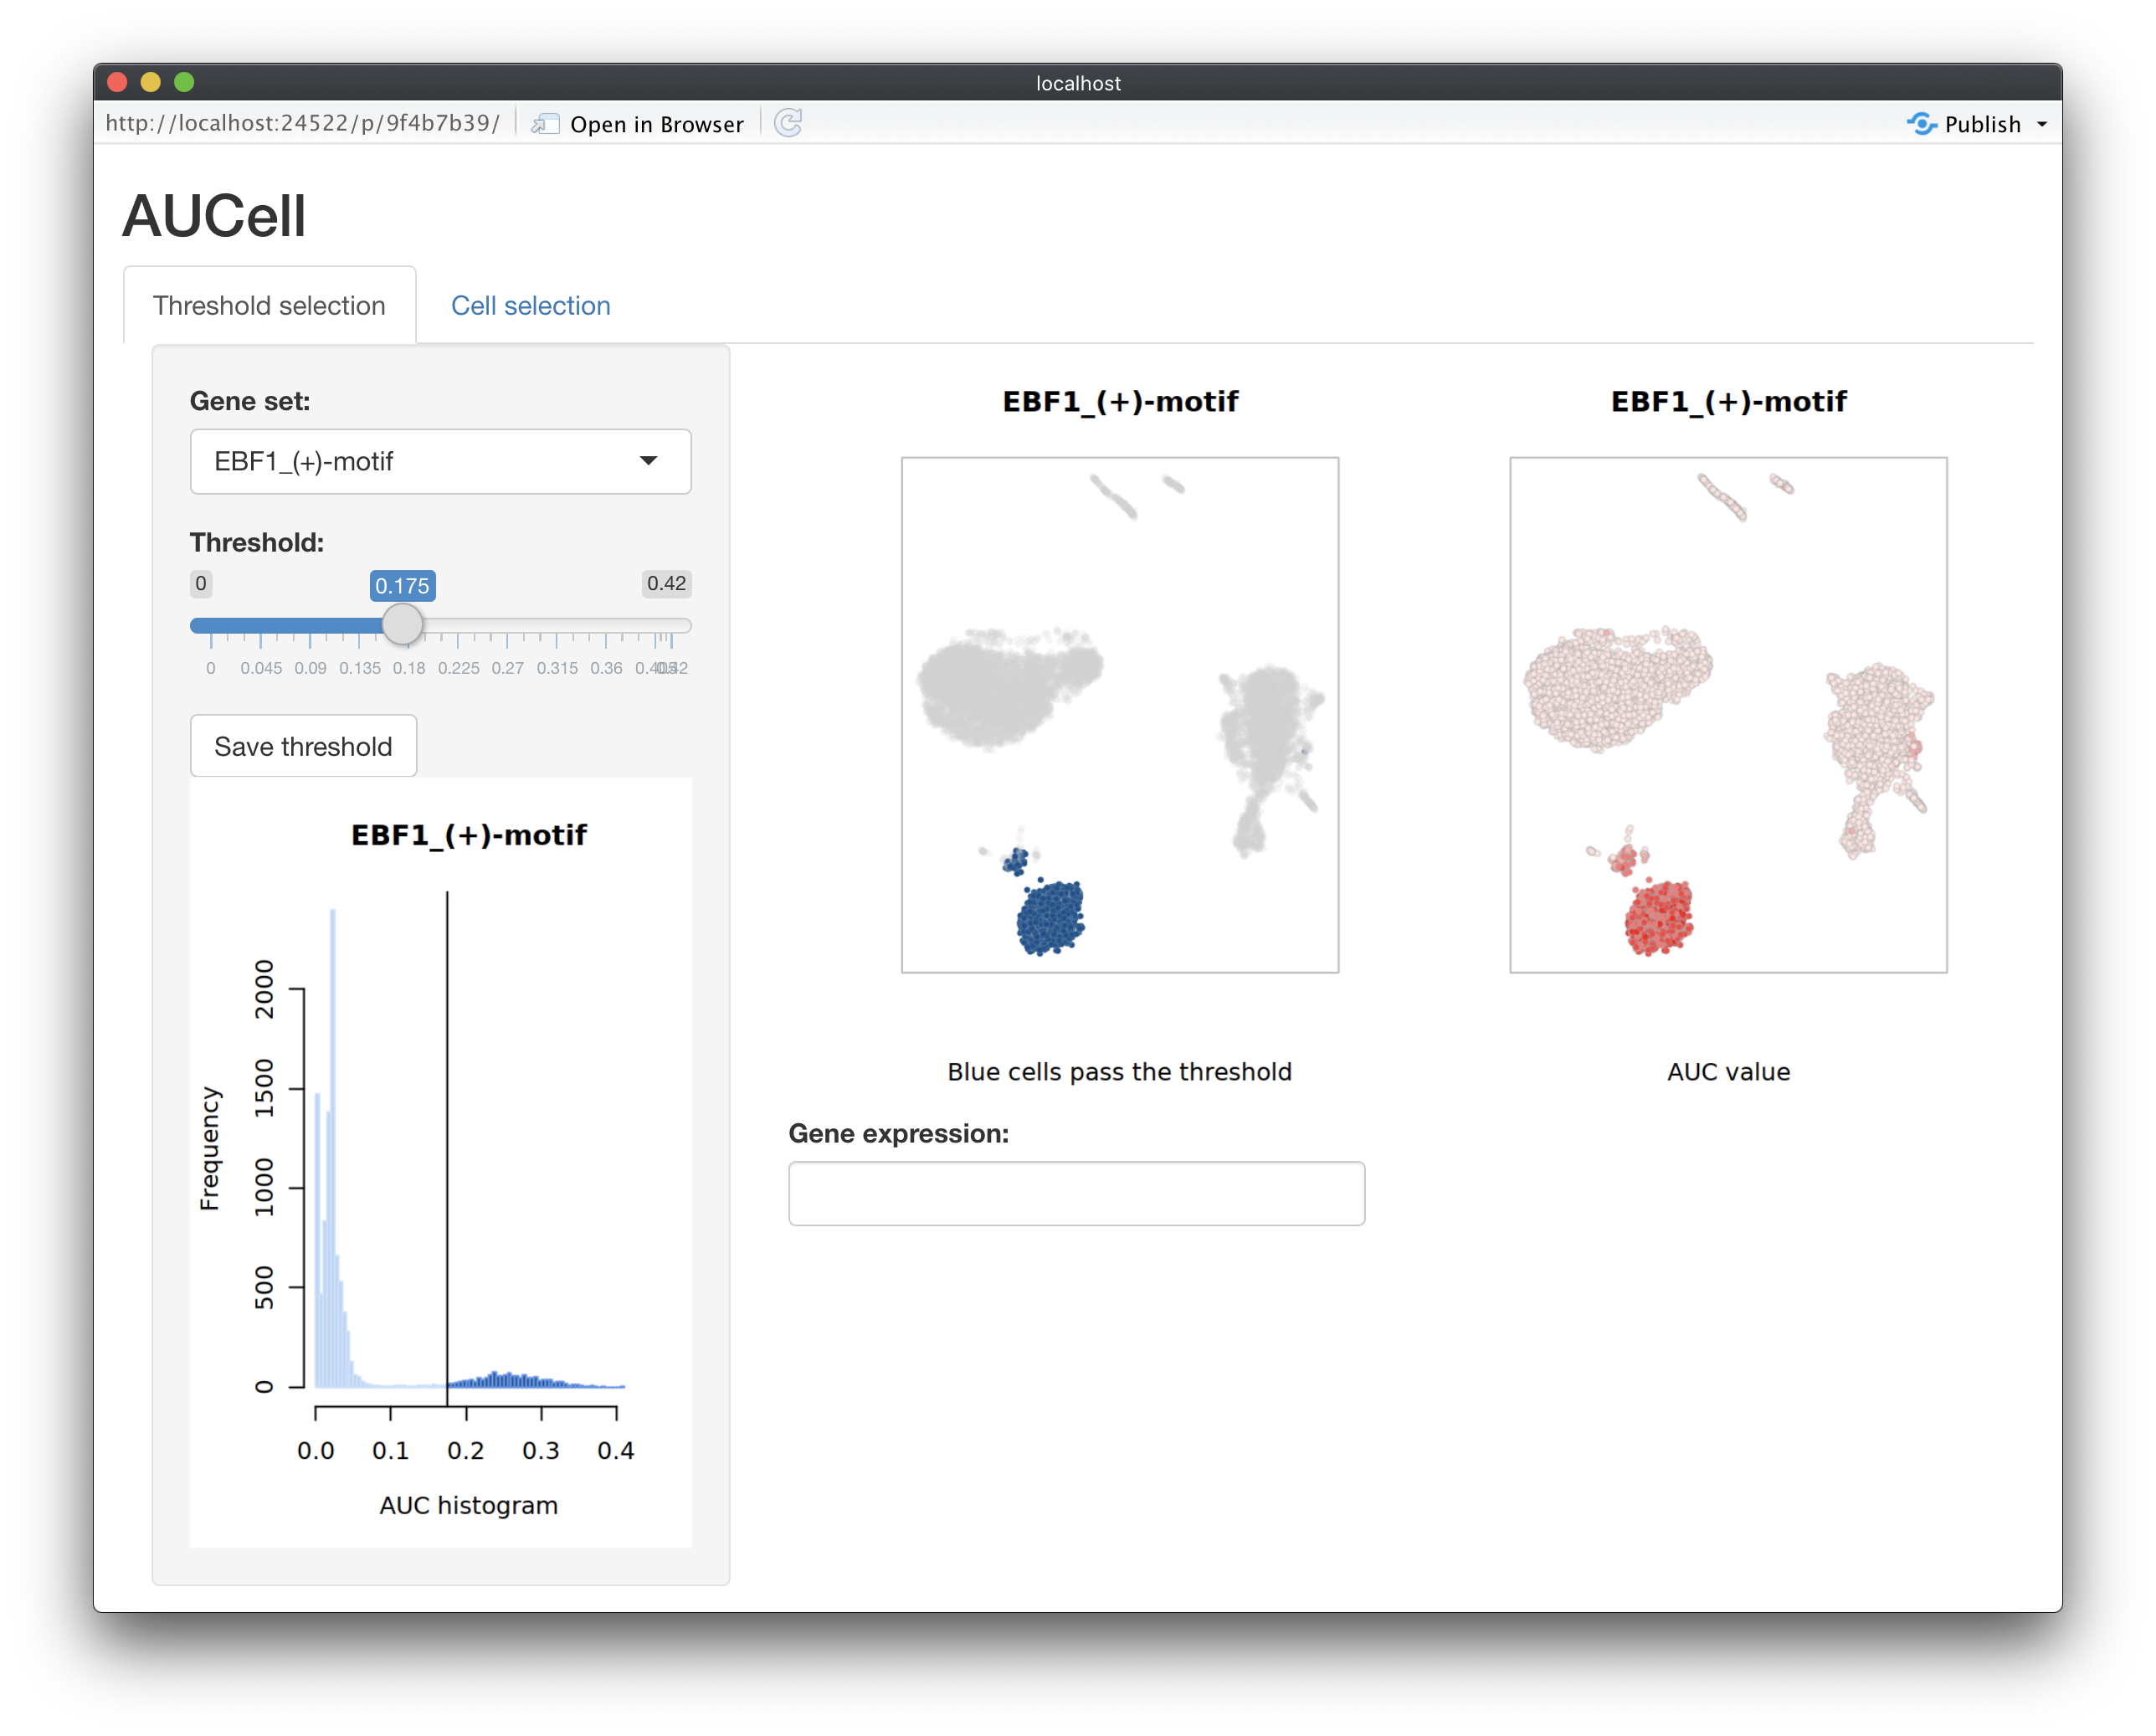

Once the binarization thresholds have been confirmed or adjusted (probably also selecting a subset of relevant regulons),
you can proceed to performing a new 2D projection or clustering on the resulting binarized activity matrix...

This is an example of the binarization and visualization of the resulting matrix as heatmap (a 2D projection is usually also useful, but it takes longer to run...):

In [ ]:
# This function will be included in the next version of AUCell
binarizeAUC <- function(auc, thresholds)
{
  thresholds <- thresholds[intersect(names(thresholds), rownames(auc))]
  regulonsCells <- setNames(lapply(names(thresholds), 
                                   function(x) {
                                     trh <- thresholds[x]
                                     names(which(getAUC(auc)[x,]>trh))
                                   }),names(thresholds))
  
  regulonActivity <- reshape2::melt(regulonsCells)
  binaryRegulonActivity <- t(table(regulonActivity[,1], regulonActivity[,2]))
  class(binaryRegulonActivity) <- "matrix"  
  
  return(binaryRegulonActivity)
}

In [ ]:
binaryRegulonActivity <- binarizeAUC(regulonAUC, regulonAucThresholds)
dim(binaryRegulonActivity)

In [ ]:
binaryRegulonActivity[1:5,1:3]

Overview of the resulting matrix (note here we have not updated the thresholds, so we using the default ones): 

In [ ]:
# Subset some cells to make the plots faster:
nCells <- 1000
set.seed(123)
cellsSelected <- sample(colnames(regulonAUC), nCells) 
binAct_subset <- binaryRegulonActivity[, which(colnames(binaryRegulonActivity) %in% cellsSelected)]
dim(binAct_subset)

In [ ]:
options(repr.plot.width=12, repr.plot.height=10) # To set the figure size in Jupyter
# binAct_subset <- binAct_subset[regulonOrder,]
ComplexHeatmap::Heatmap(binAct_subset, name="Binarized activity", 
                       col = c("white", "black"),
                        cluster_rows = TRUE, cluster_columns=TRUE,
                       show_column_names = FALSE,
                       row_names_gp=grid::gpar(fontsize=6)) # row font size

### The networks in detail: TFs, targets and motifs

The networks inferred by SCENIC are **TF-centered**: it searches for genes co-expressed with a TF (through GENIE3/GRNBoost), which also present enrichment of the TF binding motifs (for details see the paper). 
As we have seen before, these sets of TF and its potential target genes are what we call `regulons`. The union of all or some of these regulons will form a network. 

As usual, there are many potential ways to explore the networks. Here we gather a few examples for recurrent topics:
- General stats of the networks/regulons
- Identifying potential regulators for a given gene
- Gathering some more information from the regulons (i.e. the specific target genes or the motifs supporting the regulon). 
For example for TFs associated to interesting cell types/state.


Lets start with some **general statistics**...

Number of regulons:

In [ ]:
length(regulons)

Note than only regulons with 10 genes or more are scored with AUCell: 

In [ ]:
sum(lengths(regulons)>=10)

Number of target genes in each regulon:

In [ ]:
viewTable(cbind(nGenes=lengths(regulons)), options=list(pageLength=10))

> The regulons generated with VSN (and pySCENIC) follow this naming scheme: 
- TF name
- `_(+)` or `_(-)`: Whether the target genes are positively or negatively correlated with the TF
- `-motif` or `-track` sufix: Whether the regulon is based on TF-motifs or ChIP-seq tracks

- **Genes in a regulon:**

The regulons are loaded as a list with the regulon names as `names(regulons)`.

e.g. To check whether a specific TF has a regulon: 

In [ ]:
grep("EBF1", names(regulons), value=T) # paste0("^","EBF1","_")

Thus, the potential target genes for EBF1: 

In [ ]:
regulons[["EBF1_(+)-motif"]]

- **Potential regulators for a given gene**

This way, potential TFs upstream of a given gene can be found with:

In [ ]:
gene <- "CD3E"
names(regulons)[which(sapply(regulons, function(x) "CD3E" %in% x))]

Although if you have multiple genes, it might be easier to subset the incidence matrix (TF by target):

In [ ]:
dim(regulons_incidMat)

In [ ]:
genes <- c("CD3E", "MS4A1", "CD14") 
incidMat_subset <- regulons_incidMat[,genes]
incidMat_subset <- incidMat_subset[rowSums(incidMat_subset)>0,]

In [ ]:
incidMat_subset

- **Motifs supporting the regulons**

Each regulon is supported by specific *TF motifs* calculated using motif enrichment analysis (with `cisTarget`) on the co-expression modules. 
It is often interesting to also check these, both: to evaluate the overall quality of the regulon (e.g. are the motifs consistent?, are them directly annotated to this tf, or another TF in the same family? ...) as well as to plan future/validation experiments.

For example, the motifs enriched for EBF1:

In [ ]:
tableSubset <- motifEnrichment[TF=="EBF1"]
viewMotifs(tableSubset, colsToShow = c("logo", "NES", "TF" ,"Annotation"), options=list(pageLength=5))

Here only a few columns are shown, but the whole information from the motif enrichment is available in the table: 

In [ ]:
head(tableSubset)

In [ ]:
date()